In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import scipy as sc
import pickle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
import seaborn as sns

# PCA

In [2]:
# importing dataset
with open('ejle_nonan_df.pkl', 'rb') as file:
    df = pickle.load(file)

file.close()

df = df.drop(df.columns[:3], axis=1)

# Selecting X variables by excluding unwanted columns
# exclusing STATE_NAME, ST_ABBREV, CITY_NAME, LE_MEAN, LE_MEDI
X = df.drop(['LE_MEAN', 'LE_MEDI'], axis=1)

# creating separate y target variables
    # y_mean = life expectancy mean
    # y_median = life expectancy median
y_mean = df['LE_MEAN']
y_median = df['LE_MEDI']

In [3]:
# Normalizing the data to mean = 0 and variance = 1
def normalization(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mean) / std
    return X

X = normalization(X)

# Apply PCA to the training data to get 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

In [4]:
# To keep track of best performance of PCA
best_mse = 10000
best_type = ""

#### Linear Regression

In [5]:
targets = [y_mean, y_median]
target_names = ["Life expectancy mean", "Life expectancy median"]
colors = ['blue', 'red']
for i, target in enumerate(targets):
    # create copy of these to keep indexing correct in kfold cv below
    X_copy = X_pca.copy()
    y_copy = target.copy().to_numpy().reshape(-1, 1)

    mse_mean = []

    # perform k_folds for k = 3, 5, 10
    #k_folds = [3, 5, 10]
    k_folds = [5]
    for k in k_folds:
        scores = [] 
        rmse_list = [] 
        mse_list = []
        lrmodel = LinearRegression()
        cv = KFold(n_splits=k, shuffle=True)
        for train_index, test_index in cv.split(X_copy):
            X_train, X_test = X_copy[train_index], X_copy[test_index]
            y_train_fold, y_test_fold = y_copy[train_index], y_copy[test_index] # use y_train_copy
            lrmodel.fit(X_train, y_train_fold)
            y_predict = lrmodel.predict(X_test)
            scores.append(r2_score(y_test_fold, y_predict))
            rmse_list.append(np.sqrt(mean_squared_error(y_test_fold, y_predict)))
            mse_list.append(mean_squared_error(y_test_fold, y_predict))
        mse_mean.append(np.mean(mse_list))
        print(f"Mean scores for k = {k} for target {target_names[i]}:")
        print(f"\tR2: {np.mean(scores)}")
        print(f"\tRMSE: {np.mean(rmse_list)}")
        print(f"\tMSE: {np.mean(mse_list)}")
        print()
        if np.mean(mse_list) < best_mse:
            best_mse = np.mean(mse_list)
            best_type = f"linear regression for the target {target_names[i]}"
print(best_mse, best_type)

Mean scores for k = 5 for target Life expectancy mean:
	R2: 0.6101943470140598
	RMSE: 1.3931099799400979
	MSE: 1.9451016142764075

Mean scores for k = 5 for target Life expectancy median:
	R2: 0.5881320496786838
	RMSE: 1.4439619436494753
	MSE: 2.0901929367792254

1.9451016142764075 linear regression for the target Life expectancy mean


#### Polynomial Regression

In [6]:
'''targets = [y_mean, y_median]
target_names = ["Life expectancy mean", "Life expectancy median"]
colors = ['blue', 'red']
# perform k_folds for k = 3, 5, 10
#k_folds = [3, 5, 10]
k = [5]
# perform for degrees 2, 3, 4
degrees = [2, 3, 4]
bar_width = 0.35
bar_positions = np.arange(len(degrees))

fig, ax = plt.subplots()
for idx, target in enumerate(targets):
    # create copy of these to keep indexing correct in kfold cv below
    X_copy = X_pca.copy()
    y_copy = target.copy().to_numpy()

    mse_mean = []


    
    for k in k_folds:
        #mse_mean = []
        for d in degrees:

            scores = [] # to store r squared
            rmse_list = [] # to store RMSE
            mse_list = [] # to store MSE
            degree = d
            cv = KFold(n_splits=k, shuffle=True)
            for train_index, test_index in cv.split(X_copy):
                X_train, X_test = X_copy[train_index], X_copy[test_index]
                y_train_fold, y_test_fold = y_copy[train_index], y_copy[test_index] # use y_train_copy

                model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
                model.fit(X_train, y_train_fold)

                y_predict = model.predict(X_test)
                scores.append(r2_score(y_test_fold, y_predict))
                rmse_list.append(np.sqrt(mean_squared_error(y_test_fold, y_predict)))
                mse_list.append(mean_squared_error(y_test_fold, y_predict))
        mse_mean.append(np.mean(mse_list))
        print(f"Mean scores for k = {k}, degree = {d} and for target {target_names[idx]}:")
        print(f"\tR2: {np.mean(scores)}")
        print(f"\tRMSE: {np.mean(rmse_list)}")
        print(f"\tMSE: {np.mean(mse_list)}")
        print()
        if np.mean(mse_list) < best_mse:
            best_mse = np.mean(mse_list)
            best_type = f"Polynomial regression with degree = {d} for the target {target_names[idx]}"

    # plot the bar for this target
    ax.bar(bar_positions + idx * bar_width, mse_mean, width=bar_width, color=colors[idx], label=target_names[idx])

# set labels, title and legend
ax.set_xlabel('Degree of Polynomial')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE for Polynomial Regression with PCA')
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(degrees)
ax.legend()

plt.show()'''

'targets = [y_mean, y_median]\ntarget_names = ["Life expectancy mean", "Life expectancy median"]\ncolors = [\'blue\', \'red\']\n# perform k_folds for k = 3, 5, 10\n#k_folds = [3, 5, 10]\nk = [5]\n# perform for degrees 2, 3, 4\ndegrees = [2, 3, 4]\nbar_width = 0.35\nbar_positions = np.arange(len(degrees))\n\nfig, ax = plt.subplots()\nfor idx, target in enumerate(targets):\n    # create copy of these to keep indexing correct in kfold cv below\n    X_copy = X_pca.copy()\n    y_copy = target.copy().to_numpy()\n\n    mse_mean = []\n\n\n    \n    for k in k_folds:\n        #mse_mean = []\n        for d in degrees:\n\n            scores = [] # to store r squared\n            rmse_list = [] # to store RMSE\n            mse_list = [] # to store MSE\n            degree = d\n            cv = KFold(n_splits=k, shuffle=True)\n            for train_index, test_index in cv.split(X_copy):\n                X_train, X_test = X_copy[train_index], X_copy[test_index]\n                y_train_fold, y_test_f

#### Locally-weighted regression

Mean scores for k = 5 and tau = 0.01:
	R2: 0.6019199300683197
	RMSE: 1.4049484885348402
	MSE: 1.9789094820983888

[1.3697712268935458, 1.4168678232526963, 1.5222097199480427, 1.410852960763162, 1.3050407118167546]

Mean scores for k = 5 and tau = 0.05:
	R2: 0.6081053105685648
	RMSE: 1.3968325187409172
	MSE: 1.9532493197027336

[1.3870424859301989, 1.4554932205883098, 1.3949183282844224, 1.4276595701880141, 1.3190489887136412]

Mean scores for k = 5 and tau = 0.1:
	R2: 0.6056289122985833
	RMSE: 1.396561347848217
	MSE: 1.9580339411474839

[1.4735329353875914, 1.2565937816652382, 1.336909090999322, 1.429106282441705, 1.4866646487472288]

Mean scores for k = 5 and tau = 0.5:
	R2: 0.6073659008273258
	RMSE: 1.3985540100298566
	MSE: 1.9653385544020003

[1.4182393008753746, 1.3895352182665133, 1.3313730540847193, 1.2847776066737648, 1.5688448702489115]

Mean scores for k = 5 and tau = 1:
	R2: 0.6174811420809064
	RMSE: 1.3785288570148437
	MSE: 1.9061375505783693

[1.3403204341662602, 1.36366408

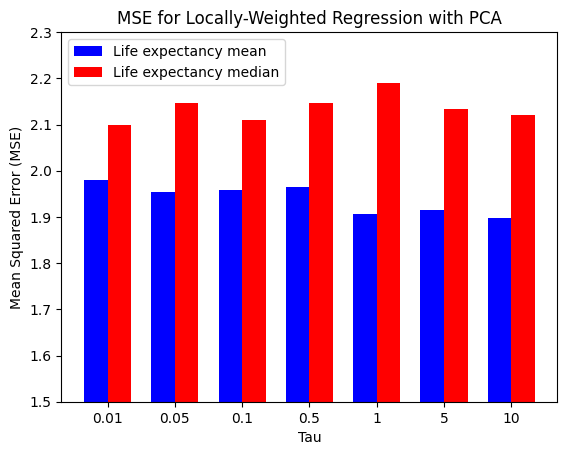

1.8968137806686556 Locally-weighted regression with tau = 10 for the target Life expectancy mean


In [7]:
def local_regression(xi, X, y, tau):
    m = X.shape[0]
    W = np.zeros((m,m))
    # fill in the weight matrix
    for i in range(m):
        xit = np.concatenate(([1], X[i, :]))  # add a 1 to the beginning of xit
        xi_ = np.concatenate(([1], xi[0, :]))  # add a 1 to the beginning of xi
        W[i, i] = np.exp(-np.dot((xi_ - xit), (xi_ - xit).T) / (2 * tau * tau))
    W += 1e-8 * np.identity(m)  # add a small constant to the diagonal to avoid zero weights
    W = W / np.sum(W, axis=0)  # normalize the weights
    lrmodel = LinearRegression()
    lrmodel.fit(X, y, sample_weight=W.diagonal())
    return lrmodel.predict(xi.reshape(1, -1))



targets = [y_mean, y_median]
target_names = ["Life expectancy mean", "Life expectancy median"]
colors = ['blue', 'red']

# perform k_folds for k = 3, 5, 10
#k_folds = [3, 5, 10]
k_folds = [5]
# define a list of bandwidths to try
tau_list = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
bar_width = 0.35
bar_positions = np.arange(len(tau_list))
fig, ax = plt.subplots()
for idx, target in enumerate(targets):
    # create copy of these to keep indexing correct in kfold cv below
    X_copy = X_pca.copy()
    y_copy = target.copy().to_numpy().reshape(-1, 1)

    mse_mean = []


    for k in k_folds:
        for tau in tau_list:
            scores = [] # to store r squared
            rmse_list = [] # to store RMSE
            mse_list = []

            kf = KFold(n_splits=k, shuffle=True)
            for train_index, test_index in kf.split(X_copy):
                X_train_fold, X_test_fold = X_copy[train_index], X_copy[test_index]
                y_train_fold, y_test_fold = y_copy[train_index], y_copy[test_index]

                # Create a copy of y_train_fold
                y_train_fold_copy = y_train_fold.copy()

                y_pred_fold = np.zeros(len(X_test_fold))
                for i in range(len(X_test_fold)):
                    y_pred_fold[i] = local_regression(X_test_fold[i].reshape(1,-1), X_train_fold, y_train_fold_copy, tau)

                scores.append(r2_score(y_test_fold, y_pred_fold))
                rmse_list.append(np.sqrt(mean_squared_error(y_test_fold, y_pred_fold)))
                mse_list.append(mean_squared_error(y_test_fold, y_pred_fold))
            mse_mean.append(np.mean(mse_list))

            print(f"Mean scores for k = {k} and tau = {tau}:")
            print(f"\tR2: {np.mean(scores)}")
            print(f"\tRMSE: {np.mean(rmse_list)}")
            print(f"\tMSE: {np.mean(mse_list)}")
            print()
            print(rmse_list)
            print()
            if np.mean(mse_list) < best_mse:
                best_mse = np.mean(mse_list)
                best_type = f"Locally-weighted regression with tau = {tau} for the target {target_names[idx]}"
        # plot the bar for this target
    ax.bar(bar_positions + idx * bar_width, mse_mean, width=bar_width, color=colors[idx], label=target_names[idx])

# set labels, title and legend
ax.set_xlabel('Tau')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE for Locally-Weighted Regression with PCA')
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(tau_list)
ax.legend()
ax.set_ylim([1.5, 2.3])

plt.show()
print(best_mse, best_type)

#### KNN

Mean scores for k = 5 and neighbors = 1 for Life expectancy mean:
	R2: 0.5817670616100578
	RMSE: 1.9160961788584192
	MSE: 3.671910590726621

[1.9079524487560067, 1.9555000127255693, 1.9160738403289672, 1.8877643401907183, 1.9131902522908353]

Mean scores for k = 5 and neighbors = 2 for Life expectancy mean:
	R2: 0.5817670616100578
	RMSE: 1.7489597880657617
	MSE: 3.069983054785799

[1.8840799142195717, 1.586999295272384, 1.7698226723871833, 1.8249957665664769, 1.6789012918831916]

Mean scores for k = 5 and neighbors = 3 for Life expectancy mean:
	R2: 0.5817670616100578
	RMSE: 1.6760351994028801
	MSE: 2.812891379550199

[1.6103001783023354, 1.6933826952226985, 1.7846069340259758, 1.6655138620553271, 1.6263723274080646]

Mean scores for k = 5 and neighbors = 4 for Life expectancy mean:
	R2: 0.5817670616100578
	RMSE: 1.6745278125420224
	MSE: 2.8088351595487198

[1.6870010093266854, 1.63244034980399, 1.5726464266217623, 1.701503756437044, 1.7790475205206293]

Mean scores for k = 5 and neigh

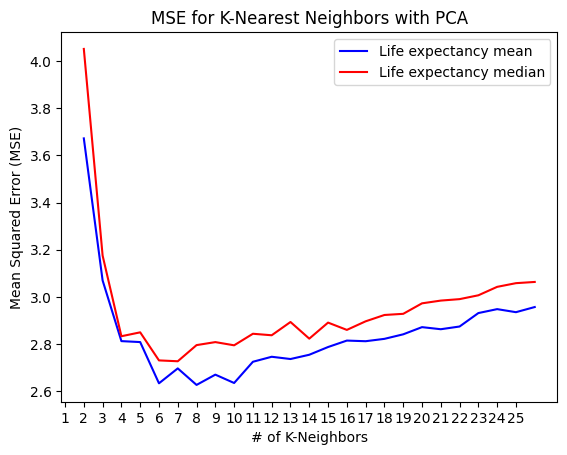

1.8968137806686556 Locally-weighted regression with tau = 10 for the target Life expectancy mean


In [8]:
targets = [y_mean, y_median]
target_names = ["Life expectancy mean", "Life expectancy median"]
colors = ['blue', 'red']
for idx, target in enumerate(targets):
    # create copy of these to keep indexing correct in kfold cv below
    X_copy = X_pca.copy()
    y_copy = target.copy().to_numpy().reshape(-1, 1)
    # Normalize the data to mean = 0 and variance = 1
    X_train_norm = normalization(X_copy)
    mse_mean = []

    # perform k_folds for k = 3, 5, 10
    #k_folds = [3, 5, 10]
    k = [5]
    # perform for degrees 2, 3, 4, 5
    neighbors = list(range(1, 26))
    for k in k_folds:
        for n in neighbors:
            rmse_list = [] # to store RMSE
            mse_list = []
            knn_model = KNeighborsRegressor(n_neighbors=n)
            cv = KFold(n_splits=5, shuffle=True)
            for train_index, test_index in cv.split(X_train_norm):
                X_train_fold, X_test_fold = X_train_norm[train_index], X_train_norm[test_index]
                y_train_fold, y_test_fold = y_copy[train_index], y_copy[test_index]
                knn_model.fit(X_train_fold, y_train_fold)
                y_predict_norm = knn_model.predict(X_test_fold)
                rmse_list.append(np.sqrt(mean_squared_error(y_test_fold, y_predict_norm)))
                mse_list.append(mean_squared_error(y_test_fold, y_predict_norm))

            mse_mean.append(np.mean(mse_list))

            print(f"Mean scores for k = {k} and neighbors = {n} for {target_names[idx]}:")
            print(f"\tR2: {np.mean(scores)}")
            print(f"\tRMSE: {np.mean(rmse_list)}")
            print(f"\tMSE: {np.mean(mse_list)}")
            print()
            print(rmse_list)
            print()
            if np.mean(mse_list) < best_mse:
                best_mse = np.mean(mse_list)
                best_type = f"KNN with neighbors = {n} for the target {target_names[idx]}"
    plt.plot(neighbors, mse_mean, color=colors[idx], label=target_names[idx])
    
plt.xlabel("# of K-Neighbors")
plt.ylabel("Mean Squared Error (MSE)")
plt.xticks(range(len(neighbors)), [str(n) for n in neighbors])
plt.title("MSE for K-Nearest Neighbors with PCA")
plt.legend()
plt.show()
print(best_mse, best_type)

#### SVR

Mean scores for k = 5 and kernel = ['linear', 'poly', 'rbf', 'sigmoid'] for Life expectancy mean:
	R2: 0.5817670616100578
	RMSE: 1.398763120434592
	MSE: 1.96439703924652

[1.4127745603684658, 1.3652725242141548, 1.5237876251793063, 1.437573422875742, 1.2544074695352907]

Mean scores for k = 5 and kernel = ['linear', 'poly', 'rbf', 'sigmoid'] for Life expectancy mean:
	R2: 0.5817670616100578
	RMSE: 2.3145368965411492
	MSE: 5.964034739640877

[2.012937516125091, 1.8461968399625248, 2.017476024928771, 1.8314314524530486, 3.86464264923631]

Mean scores for k = 5 and kernel = ['linear', 'poly', 'rbf', 'sigmoid'] for Life expectancy mean:
	R2: 0.5817670616100578
	RMSE: 1.3970230777981787
	MSE: 1.9522528286134804

[1.403262076617056, 1.4341065580919803, 1.3734967722052056, 1.406271826926999, 1.3679781551496522]

Mean scores for k = 5 and kernel = ['linear', 'poly', 'rbf', 'sigmoid'] for Life expectancy mean:
	R2: 0.5817670616100578
	RMSE: 1.5008039086542362
	MSE: 2.2541708687441764

[1.568635

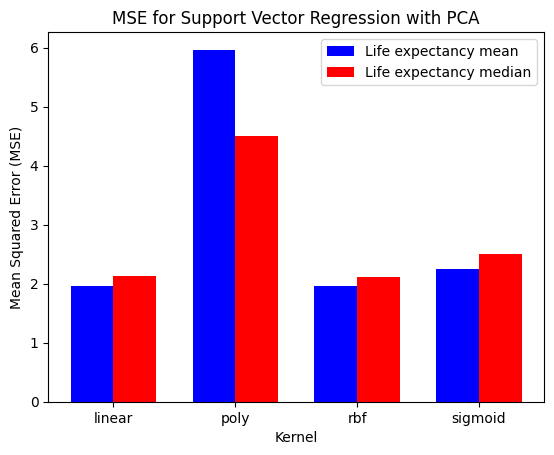

1.8968137806686556 Locally-weighted regression with tau = 10 for the target Life expectancy mean


In [9]:
targets = [y_mean, y_median]
target_names = ["Life expectancy mean", "Life expectancy median"]
colors = ['blue', 'red']
# perform for different kernels
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
bar_width = 0.35
bar_positions = np.arange(len(kernel))

fig, ax = plt.subplots()
for idx, target in enumerate(targets):
    # create copy of these to keep indexing correct in kfold cv below
    X_copy = X_pca.copy()
    y_copy = target.copy().to_numpy().reshape(-1,)
    # Normalize the data to mean = 0 and variance = 1
    X_train_norm = normalization(X_copy)
    mse_mean = []



    # perform k_folds for k = 3, 5, 10
    #k_folds = [3, 5, 10]
    k = [5]
  
    for k in k_folds:
        for ker in kernel:
            rmse_list = [] # to store RMSE
            mse_list = []
            svr_model = SVR(kernel=ker)
            cv = KFold(n_splits=k, shuffle=True)
            for train_index, test_index in cv.split(X_train_norm):
                X_train_fold, X_test_fold = X_train_norm[train_index], X_train_norm[test_index]
                y_train_fold, y_test_fold = y_copy[train_index], y_copy[test_index]
                svr_model.fit(X_train_fold, y_train_fold)
                y_predict_norm = svr_model.predict(X_test_fold)
                rmse_list.append(np.sqrt(mean_squared_error(y_test_fold, y_predict_norm)))
                mse_list.append(mean_squared_error(y_test_fold, y_predict_norm))

            mse_mean.append(np.mean(mse_list))

            print(f"Mean scores for k = {k} and kernel = {kernel} for {target_names[idx]}:")
            print(f"\tR2: {np.mean(scores)}")
            print(f"\tRMSE: {np.mean(rmse_list)}")
            print(f"\tMSE: {np.mean(mse_list)}")
            print()
            print(rmse_list)
            print()
            if np.mean(mse_list) < best_mse:
                best_mse = np.mean(mse_list)
                best_type = f"SVR with kernel = {ker} for the target {target_names[idx]}"
    # plot the bar for this target
    ax.bar(bar_positions + idx * bar_width, mse_mean, width=bar_width, color=colors[idx], label=target_names[idx])

# set labels, title and legend
ax.set_xlabel('Kernel')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE for Support Vector Regression with PCA')
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(kernel)
ax.legend()

plt.show()
print(best_mse, best_type)

In [10]:
print("For PCA, the lowest MSE value with kfold cv of k = 5 is:")
print(f"\t {best_type}")
print(f"\t MSE = {best_mse}")

For PCA, the lowest MSE value with kfold cv of k = 5 is:
	 Locally-weighted regression with tau = 10 for the target Life expectancy mean
	 MSE = 1.8968137806686556


# Filter Method

In [11]:
'''
Filter method to perform feature selection
@param X - data inputs (pandas Dataframe)
       y - data targets (pandas DataFrame)
       threshold - correlation value to be above to be selected as feature
       feature_type - either "MEAN" or "MEDI" to indicate what type of features to include
@return features - selected features (list)
'''
def Filter(X, y, threshold, feature_type, num_features):
    # filter feature names to only include those that contain "MEAN" or "MEDI"
    #names = [col for col in X.columns if feature_type in col]
    names = [col for col in X.columns]
    X_filtered = X[names]
    X_filtered = X

    mi = mutual_info_regression(X_filtered, y)
    mi = pd.Series(mi)
    mi.index = names
    top_mi = mi.sort_values(ascending=False)[:num_features]
    #top_mi.plot.bar(figsize=(10, 4))
    #plt.xlabel('Features')
    #plt.ylabel('Mutual Information')
    #plt.title('Top 10 Features by Mutual Information')
    #plt.show()
    return top_mi.sort_values(ascending=False)



In [12]:
# importing dataset
with open('ejle_nonan_df.pkl', 'rb') as file:
    df = pickle.load(file)

file.close()

df = df.drop(df.columns[:3], axis=1)

# Selecting X variables by excluding unwanted columns
# exclusing STATE_NAME, ST_ABBREV, CITY_NAME, LE_MEAN, LE_MEDI
X = df.drop(['LE_MEAN', 'LE_MEDI'], axis=1)

# creating separate y target variables
    # y_mean = life expectancy mean
    # y_median = life expectancy median
y_mean = df['LE_MEAN']
y_median = df['LE_MEDI']

In [13]:
num_features = 25
mean_features = Filter(X, y_mean, 0.5, "MEAN", num_features)

In [14]:
print(mean_features)

LOWINCPCT_MEAN     0.276481
LOWINCPCT_MEDI     0.254099
LESSHSPCT_MEAN     0.252402
LESSHSPCT_MEDI     0.251397
REGION_MEAN        0.230671
REGION_MEDI        0.224663
CANCER_MEAN        0.157247
VULEOPCT_MEDI      0.147255
UNEMPPCT_MEAN      0.142522
VULEOPCT_MEAN      0.131252
P_RESP_MEDI        0.130980
P_CANCR_MEDI       0.130448
RESP_MEAN          0.122375
D_LDPNT_2_MEDI     0.122030
RESP_MEDI          0.114990
CANCER_MEDI        0.111160
UNEMPPCT_STDV      0.105578
D_LDPNT_2_MEAN     0.100659
P_VULEOPCT_MEAN    0.094191
UNEMPPCT_MEDI      0.093771
D_RESP_2_MEDI      0.093521
D_CANCR_2_MEAN     0.092620
D_CANCR_2_MEDI     0.090602
PM25_MEDI          0.090375
P_LWINCPCT_MEDI    0.081330
dtype: float64


In [15]:
# Convert the Pandas Series to a list of column names
selected_features = list(mean_features.index)[:num_features]

# Select only the rows of X that have column names in mean_features
X_select = X.loc[:, selected_features]

In [16]:
# define best_mse and type for feature selection
best_mse2 = 10000
best_type2 = ""

#### Linear Regression

Mean scores for num_features = 1 for target Life expectancy mean:
	R2: 0.3640066005223942
	RMSE: 1.7784038485644025
	MSE: 3.167905452425976

Mean scores for num_features = 2 for target Life expectancy mean:
	R2: 0.36103920213216667
	RMSE: 1.7800538582587655
	MSE: 3.171087997085118

Mean scores for num_features = 3 for target Life expectancy mean:
	R2: 0.3582811304146266
	RMSE: 1.7786437334788672
	MSE: 3.1693650280495524

Mean scores for num_features = 4 for target Life expectancy mean:
	R2: 0.3695108895189171
	RMSE: 1.7730468297254405
	MSE: 3.1549013299301585

Mean scores for num_features = 5 for target Life expectancy mean:
	R2: 0.42023130799300834
	RMSE: 1.6989560367829497
	MSE: 2.902281774802216

Mean scores for num_features = 6 for target Life expectancy mean:
	R2: 0.4191789550557446
	RMSE: 1.6985195826060615
	MSE: 2.886237096862407

Mean scores for num_features = 7 for target Life expectancy mean:
	R2: 0.4581213840353472
	RMSE: 1.6435065923044405
	MSE: 2.712490060752995

Mean scor

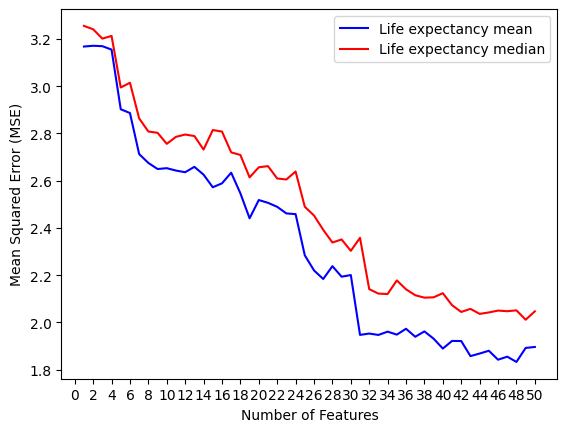

1.8325217532713516 Linear regression for 48 features for the target Life expectancy mean


In [17]:
targets = [y_mean, y_median]
target_names = ["Life expectancy mean", "Life expectancy median"]
colors = ['blue', 'red']
key_word = ["MEAN", "MEDI"]
k_folds = [5]
for idx, target in enumerate(targets):
    mse_mean = []
    for i in range(1, 51):
        mean_features = Filter(X, y_mean, 0.5, key_word[idx], i)
        # Convert the Pandas Series to a list of column names
        selected_features = list(mean_features.index)[:i]

        # Select only the rows of X that have column names in mean_features
        X_select = X.loc[:, selected_features]
        
        # create copy of these to keep indexing correct in kfold cv below
        X_train_copy = X_select.copy()
        y_train_copy = target.copy()
        
        
        # perform k_folds for k = 3, 5, 10
        #k_folds = [3, 5, 10]
        k = [5]
        for k in k_folds:
            scores = [] 
            rmse_list = [] 
            mse_list = []
            lrmodel = LinearRegression()
            cv = KFold(n_splits=k, shuffle=True)
            for train_index, test_index in cv.split(X_train_copy):
                X_train, X_test = X_train_copy.iloc[train_index], X_train_copy.iloc[test_index]
                y_train_fold, y_test_fold = y_train_copy.iloc[train_index], y_train_copy.iloc[test_index] # use y_train_copy
                lrmodel.fit(X_train, y_train_fold)
                y_predict = lrmodel.predict(X_test)
                scores.append(r2_score(y_test_fold, y_predict))
                rmse_list.append(np.sqrt(mean_squared_error(y_test_fold, y_predict)))
                mse_list.append(mean_squared_error(y_test_fold, y_predict))
        mse_mean.append(np.mean(mse_list))
        print(f"Mean scores for num_features = {i} for target {target_names[idx]}:")
        print(f"\tR2: {np.mean(scores)}")
        print(f"\tRMSE: {np.mean(rmse_list)}")
        print(f"\tMSE: {np.mean(mse_list)}")
        print()
        if np.mean(mse_list) < best_mse2:
            best_mse2 = np.mean(mse_list)
            best_type2 = f"Linear regression for {i} features for the target {target_names[idx]}"

    plt.plot(range(1, 51), mse_mean, color=colors[idx], label=target_names[idx])
    
plt.xlabel("Number of Features")
plt.ylabel("Mean Squared Error (MSE)")
plt.xticks(range(0,51, 2))
plt.legend()
plt.show()
print(best_mse2, best_type2)

#### Polynomial Regression

In [18]:
'''
for i in range(1, 26):
    mean_features = Filter(X, y_mean, 0.5, "MEAN", i)
    # Convert the Pandas Series to a list of column names
    selected_features = list(mean_features.index)[:i]
    print(selected_features)
    # Select only the rows of X that have column names in mean_features
    X_select = X.loc[:, selected_features]
    # perform k_folds for k = 3, 5, 10
    # split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_select, y_mean)
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    # create a copy of y_train
    y_train_copy = y_train.copy()
    X_train_copy = X_train.copy()
    k_folds = [3, 5, 10]
    for k in k_folds:
        scores = [] 
        rmse_list = [] 
        mse_list = []
        cv = KFold(n_splits=5, shuffle=True)
        for train_index, test_index in cv.split(X_train_copy):
            X_train_fold, X_test_fold = X_train_copy[train_index], X_train_copy[test_index]
            y_train_fold, y_test_fold = y_train_copy[train_index], y_train_copy[test_index] # use y_train_copy

            model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
            model.fit(X_train_fold, y_train_fold)

            y_predict = model.predict(X_test_fold)
            scores.append(r2_score(y_test_fold, y_predict))
            rmse_list.append(np.sqrt(mean_squared_error(y_test_fold, y_predict)))
            mse_list.append(mean_squared_error(y_test_fold, y_predict))

        print(f"Mean scores for k = {k} with {i} features:")
        print(f"\tR2: {np.mean(scores)}")
        print(f"\tRMSE: {np.mean(rmse_list)}")
        print(f"\tMSE: {np.mean(mse_list)}")
        print()
        if np.mean(mse_list) < best_mse2:
            best_mse2 = np.mean(mse_list)
            best_type2 = f"Linear regression for {i} features for the {target target_names[idx]}"
'''
# takes way too long and not greater mse values >> 1000

'\nfor i in range(1, 26):\n    mean_features = Filter(X, y_mean, 0.5, "MEAN", i)\n    # Convert the Pandas Series to a list of column names\n    selected_features = list(mean_features.index)[:i]\n    print(selected_features)\n    # Select only the rows of X that have column names in mean_features\n    X_select = X.loc[:, selected_features]\n    # perform k_folds for k = 3, 5, 10\n    # split the dataset\n    X_train, X_test, y_train, y_test = train_test_split(X_select, y_mean)\n    X_train = X_train.values\n    X_test = X_test.values\n    y_train = y_train.values\n    y_test = y_test.values\n\n    # create a copy of y_train\n    y_train_copy = y_train.copy()\n    X_train_copy = X_train.copy()\n    k_folds = [3, 5, 10]\n    for k in k_folds:\n        scores = [] \n        rmse_list = [] \n        mse_list = []\n        cv = KFold(n_splits=5, shuffle=True)\n        for train_index, test_index in cv.split(X_train_copy):\n            X_train_fold, X_test_fold = X_train_copy[train_index], X

#### Locally weighted Regressoin

Mean scores for k = 5 and tau = 0.01:
	R2: 0.5954597484644166
	MSE: 1.9302625719824724

[1.9302625719824724]

Mean scores for k = 5 and tau = 0.01:
	R2: 0.5961111281513195
	MSE: 1.9439941486790162

[1.9302625719824724, 1.95772572537556]

Mean scores for k = 5 and tau = 0.01:
	R2: 0.5975437734635778
	MSE: 1.9287210817541496

[1.9302625719824724, 1.95772572537556, 1.8981749479044159]

Mean scores for k = 5 and tau = 0.01:
	R2: 0.5972624107580511
	MSE: 1.9518833981731478

[1.9302625719824724, 1.95772572537556, 1.8981749479044159, 2.021370347430142]

Mean scores for k = 5 and tau = 0.01:
	R2: 0.5976358127441871
	MSE: 1.9570595510134023

[1.9302625719824724, 1.95772572537556, 1.8981749479044159, 2.021370347430142, 1.9777641623744202]

Mean scores for k = 5 and tau = 0.05:
	R2: 0.5971055814424532
	MSE: 2.0639024751695634

[2.0639024751695634]

Mean scores for k = 5 and tau = 0.05:
	R2: 0.5981197506787096
	MSE: 1.989124670350774

[2.0639024751695634, 1.9143468655319844]

Mean scores for k = 5

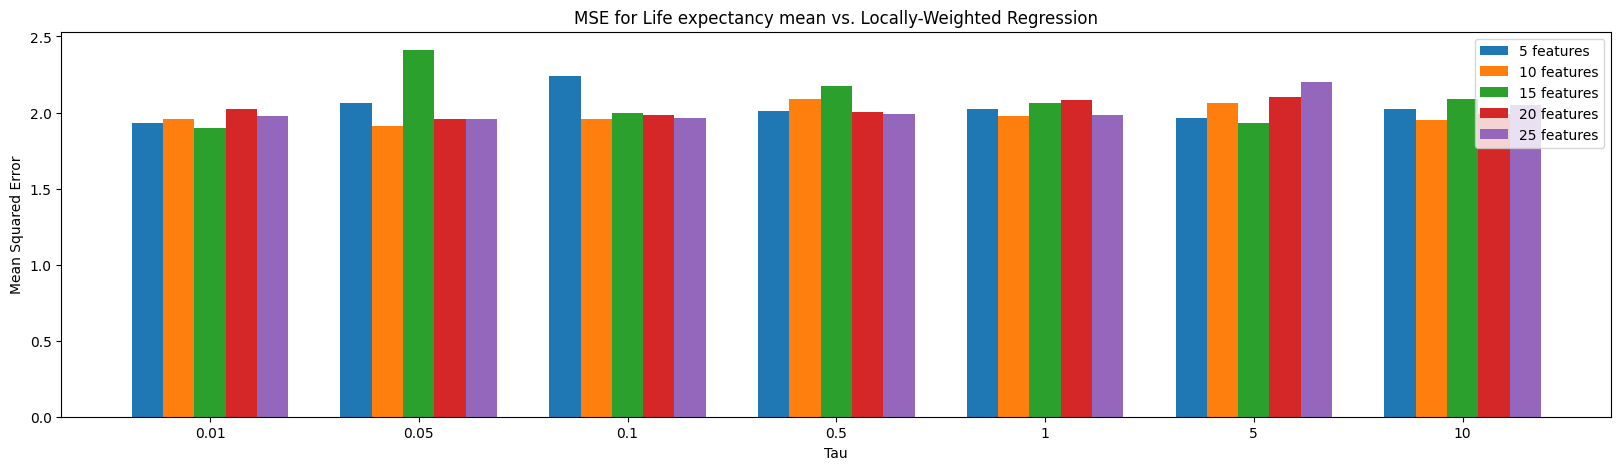

Mean scores for k = 5 and tau = 0.01:
	R2: 0.5882470552241972
	MSE: 3.1986723087839666

[3.1986723087839666]

Mean scores for k = 5 and tau = 0.01:
	R2: 0.5880825338957604
	MSE: 2.665148912672713

[3.1986723087839666, 2.131625516561459]

Mean scores for k = 5 and tau = 0.01:
	R2: 0.5878376125536565
	MSE: 2.4924253981371622

[3.1986723087839666, 2.131625516561459, 2.146978369066061]

Mean scores for k = 5 and tau = 0.01:
	R2: 0.5874310797129781
	MSE: 2.4153118770654878

[3.1986723087839666, 2.131625516561459, 2.146978369066061, 2.183971313850464]

Mean scores for k = 5 and tau = 0.01:
	R2: 0.5868587866964948
	MSE: 2.3779969628433397

[3.1986723087839666, 2.131625516561459, 2.146978369066061, 2.183971313850464, 2.228737305954746]

Mean scores for k = 5 and tau = 0.05:
	R2: 0.5858286563417046
	MSE: 2.37777410149497

[2.37777410149497]

Mean scores for k = 5 and tau = 0.05:
	R2: 0.5858911737193713
	MSE: 2.2342628857904216

[2.37777410149497, 2.0907516700858735]

Mean scores for k = 5 and t

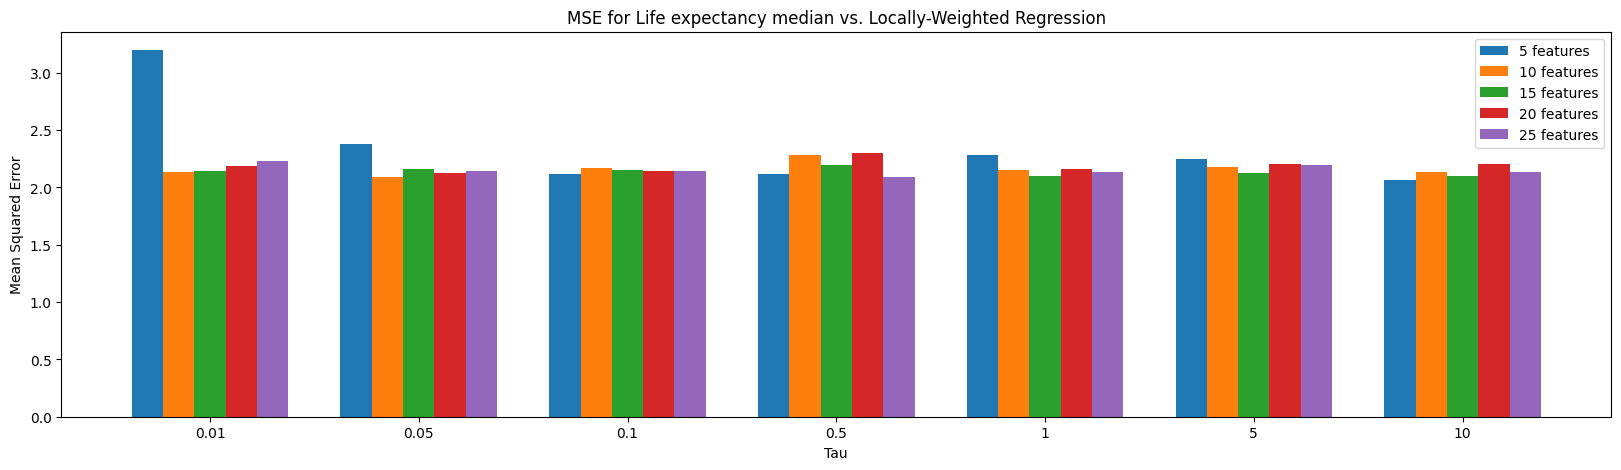

1.8325217532713516 Linear regression for 48 features for the target Life expectancy mean


In [20]:
def local_regression(xi, X, y, tau):
    m = X.shape[0]
    W = np.zeros((m,m))
    # fill in the weight matrix
    for i in range(m):
        xit = np.concatenate(([1], X[i, :]))  # add a 1 to the beginning of xit
        xi_ = np.concatenate(([1], xi[0, :]))  # add a 1 to the beginning of xi
        W[i, i] = np.exp(-np.dot((xi_ - xit), (xi_ - xit).T) / (2 * tau * tau))
    W += 1e-8 * np.identity(m)  # add a small constant to the diagonal to avoid zero weights
    W = W / np.sum(W, axis=0)  # normalize the weights
    lrmodel = LinearRegression()
    lrmodel.fit(X, y, sample_weight=W.diagonal())
    return lrmodel.predict(xi.reshape(1, -1))

targets = [y_mean, y_median]
target_names = ["Life expectancy mean", "Life expectancy median"]
colors = ['blue', 'red']
key_word = ["MEAN", "MEDI"]
num_features = [5, 10, 15, 20, 25]






# perform k_folds for k = 3, 5, 10
#k_folds = [3, 5, 10]
k_folds = [5]
# define a list of bandwidths to try
tau_list = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
width = 0.15
x_pos = np.arange(len(tau_list)) + len(num_features) * width / 2 # Modify x_pos array
colors = plt.cm.tab10(np.arange(len(num_features)))



for idx, target in enumerate(targets):
    fig, axs = plt.subplots(1, len(k_folds), figsize=(20, 5), sharey=True)
    #for i in num_features:
    for k in k_folds:     
        mse_tau = []

        #for k in k_folds:
        for tau in tau_list:
            mse_list = []
            
            #for tau in tau_list:
            for nf in num_features:
                mean_features = Filter(X, y_mean, 0.5, key_word[idx], i)
                # Convert the Pandas Series to a list of column names
                selected_features = list(mean_features.index)[:i]

                # Select only the rows of X that have column names in mean_features
                X_select = X.loc[:, selected_features]

                X_train_copy = X_select.values.copy()
                y_train = target.to_numpy().reshape(-1,1)
                kf = KFold(n_splits=k, shuffle=True)
                mse_list_k = []
                for train_index, test_index in kf.split(X_train_copy):
                    X_train_fold, X_test_fold = X_train_copy[train_index], X_train_copy[test_index]
                    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

                    # Create a copy of y_train_fold
                    y_train_fold_copy = y_train_fold.copy()

                    y_pred_fold = np.zeros(len(X_test_fold))
                    for i in range(len(X_test_fold)):
                        y_pred_fold[i] = local_regression(X_test_fold[i].reshape(1,-1), X_train_fold, y_train_fold_copy, tau)

                    scores.append(r2_score(y_test_fold, y_pred_fold))
                    mse_list_k.append(mean_squared_error(y_test_fold, y_pred_fold))
                mse_list.append(np.mean(mse_list_k))
                print(f"Mean scores for k = {k} and tau = {tau}:")
                print(f"\tR2: {np.mean(scores)}")
                print(f"\tMSE: {np.mean(mse_list)}")
                print()
                print(mse_list)
                print()
                if np.mean(mse_list) < best_mse2:
                    best_mse2 = np.mean(mse_list)
                    best_type2 = f"Locally-weighted regression for {nf} features and tau = {tau} for the target {target_names[idx]}"
            mse_tau.append(mse_list)

         # Create a bar plot for each number of features
        width = 0.15
        for i, nf in enumerate(num_features):
            axs.bar(x_pos + i * width, [mse_tau[j][i] for j in range(len(tau_list))], width, label=f'{nf} features', color=colors[i])

        axs.set_xticks(x_pos + width * (len(num_features) - 1) / 2)
        axs.set_xticklabels(tau_list)
        axs.set_xlabel('Tau')
        axs.set_ylabel('Mean Squared Error')
        axs.set_title(f"MSE for {target_names[idx]} vs. Locally-Weighted Regression")
        axs.legend()
        #ax.set_yscale("log")
        ax.set_ylim([1.5, 2.3])
        plt.show()
print(best_mse2, best_type2)

#### KNN

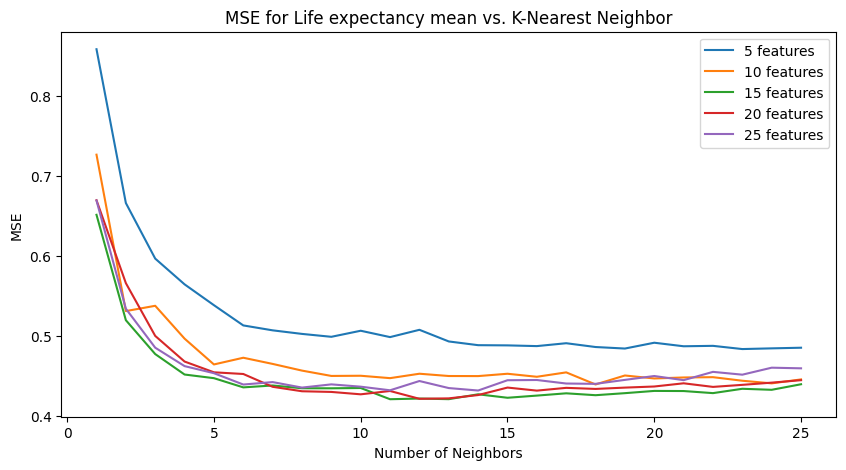

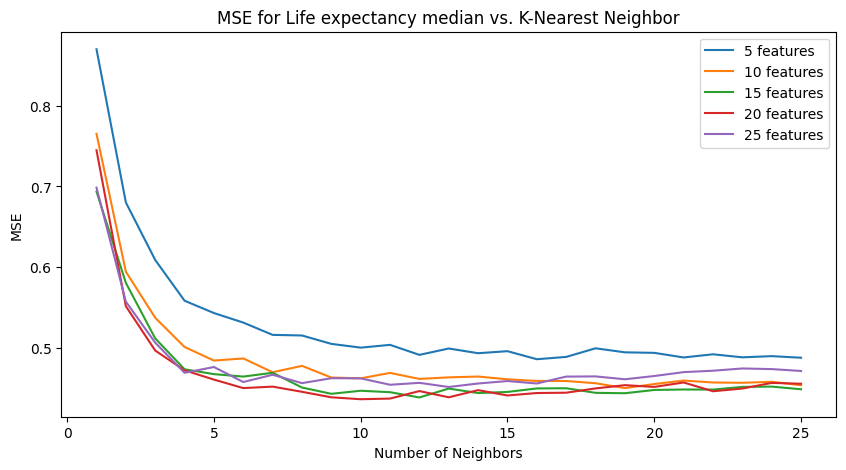

0.42084731002886666 KNN for 15 neighbors for the target Life expectancy mean


In [21]:
targets = [y_mean, y_median]
target_names = ["Life expectancy mean", "Life expectancy median"]
colors = ['blue', 'red']
key_word = ["MEAN", "MEDI"]
num_features = [5, 10, 15, 20, 25]
neighbors = list(range(1, 26))

for idx, target in enumerate(targets):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    for i in num_features:
        mean_features = Filter(X, y_mean, 0.5, key_word[idx], i)
        # Convert the Pandas Series to a list of column names
        selected_features = list(mean_features.index)[:i]

        # Select only the rows of X that have column names in mean_features
        X_select = X.loc[:, selected_features]
        
        # create copy of these to keep indexing correct in kfold cv below
        X_train_norm = normalization(X_select.values)
        y_train_norm = normalization(target)

        mse_list = []
        for n in neighbors:
            knn_model = KNeighborsRegressor(n_neighbors=n)
            cv = KFold(n_splits=5, shuffle=True)
            mse_list_k = []
            for train_index, test_index in cv.split(X_train_norm):
                X_train_fold, X_test_fold = X_train_norm[train_index], X_train_norm[test_index]
                y_train_fold, y_test_fold = y_train_norm.iloc[train_index], y_train_norm.iloc[test_index]
                knn_model.fit(X_train_fold, y_train_fold)
                y_predict_norm = knn_model.predict(X_test_fold)
                mse_list_k.append(mean_squared_error(y_test_fold, y_predict_norm))
            mse_list.append(np.mean(mse_list_k))
            if np.mean(mse_list_k) < best_mse2:
                best_mse2 = np.mean(mse_list_k)
                best_type2 = f"KNN for {i} neighbors for the target {target_names[idx]}"

        axs.plot(neighbors, mse_list, label=f'{i} features')
        axs.set_title(f"MSE for {target_names[idx]} vs. K-Nearest Neighbor")
        axs.set_xlabel("Number of Neighbors")
        axs.set_ylabel("MSE")
        axs.legend()
    plt.show()
print(best_mse2, best_type2)

#### SVR

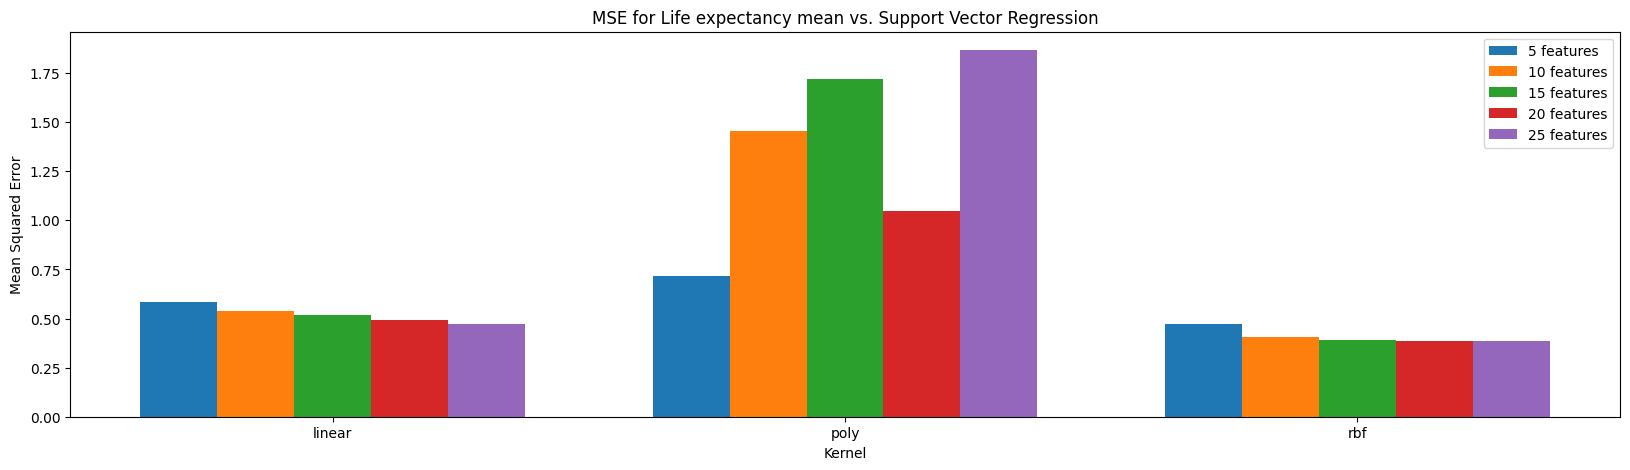

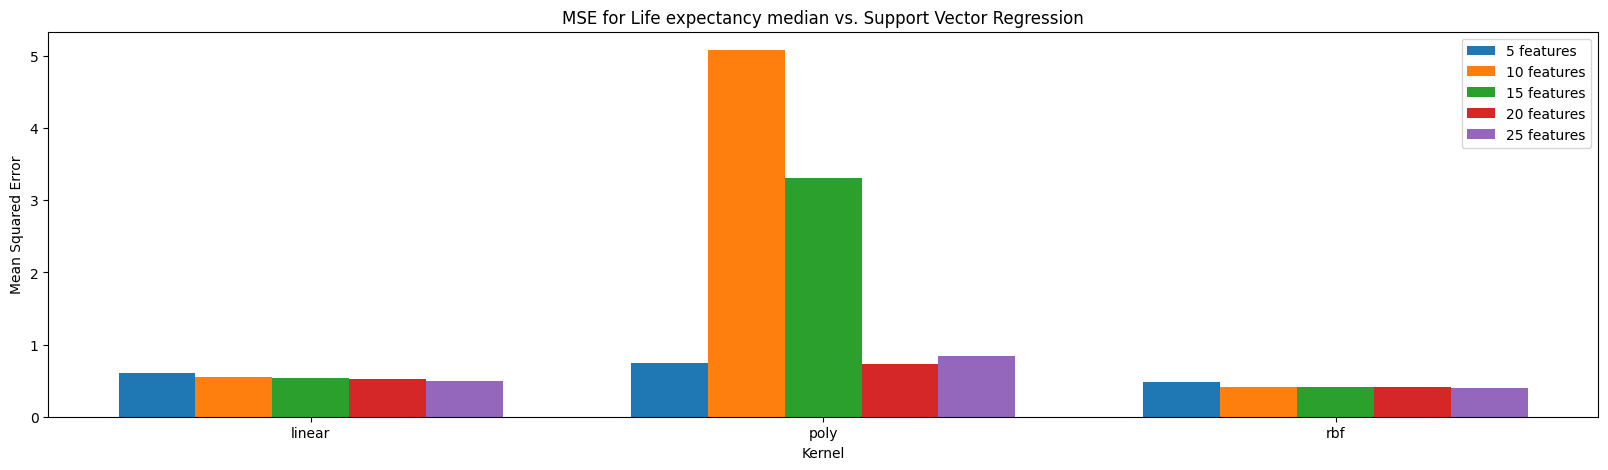

0.3841978282811936 SVR for 25 features and kernel = rbf for the target Life expectancy mean


In [22]:
# Define the targets, target names, number of features, k folds, and kernels
targets = [y_mean, y_median]
target_names = ["Life expectancy mean", "Life expectancy median"]
num_features = [5, 10, 15, 20, 25]
k_folds = [5]
kernels = ['linear', 'poly', 'rbf']
key_word = ["MEAN", "MEDI"]
width = 0.15
x_pos = np.arange(len(kernels)) + len(num_features) * width / 2 # Modify x_pos array
colors = plt.cm.tab10(np.arange(len(num_features)))
# Loop over the targets and plot the MSE for each kernel and number of features
for idx, target in enumerate(targets):
    fig, axs = plt.subplots(1, len(k_folds), figsize=(20, 5), sharey=True)
    for k_idx, k in enumerate(k_folds):
        mse_kernel = []
        for ker in kernels:
            mse_list = []
            for i in num_features:
                mean_features = Filter(X, y_mean, 0.5, key_word[idx], i)
                selected_features = list(mean_features.index)[:i]
                X_select = X.loc[:, selected_features]
                X_train_norm = normalization(X_select.values)
                y_train_norm = normalization(target)
                svr_model = SVR(kernel=ker)
                cv = KFold(n_splits=k, shuffle=True)
                mse_list_k = []
                for train_index, test_index in cv.split(X_train_norm):
                    X_train_fold, X_test_fold = X_train_norm[train_index], X_train_norm[test_index]
                    y_train_fold, y_test_fold = y_train_norm.iloc[train_index], y_train_norm.iloc[test_index]
                    svr_model.fit(X_train_fold, y_train_fold)
                    y_predict_norm = svr_model.predict(X_test_fold)
                    mse_list_k.append(mean_squared_error(y_test_fold, y_predict_norm))
                mse_list.append(np.mean(mse_list_k))
                if np.mean(mse_list_k) < best_mse2:
                    best_mse2 = np.mean(mse_list_k)
                    best_type2 = f"SVR for {i} features and kernel = {ker} for the target {target_names[idx]}"
            mse_kernel.append(mse_list)

        # Create a bar plot for each number of features
        width = 0.15
        for i, nf in enumerate(num_features):
            axs.bar(x_pos + i * width, [mse_kernel[j][i] for j in range(len(kernels))], width, label=f'{nf} features', color=colors[i])

        axs.set_xticks(x_pos + width * (len(num_features) - 1) / 2)
        axs.set_xticklabels(kernels)
        axs.set_xlabel('Kernel')
        axs.set_ylabel('Mean Squared Error')
        axs.set_title(f"MSE for {target_names[idx]} vs. Support Vector Regression")
        axs.legend()
        ax.set_yscale("log")

        plt.show()
print(best_mse2, best_type2)

In [23]:
print("For feature selection, the lowest MSE value with kfold cv of k = 5 is:")
print(f"\t {best_type2}")
print(f"\t MSE = {best_mse2}")
best_type_overall = ""
if (best_mse < best_mse2):
      best_mse_overall = best_mse
      best_type_overall = best_type
      method = "PCA"
else:
      best_mse_overall = best_mse2
      best_type_overall = best_type2
      method = "filter"
print(f"The best overall MSE from both PCA and Feature selection is with the method {method}")
print(f"\t {best_type_overall}")
print(f"\t MSE = {best_mse_overall}")

For feature selection, the lowest MSE value with kfold cv of k = 5 is:
	 SVR for 25 features and kernel = rbf for the target Life expectancy mean
	 MSE = 0.3841978282811936
The best overall MSE from both PCA and Feature selection is with the method filter
	 SVR for 25 features and kernel = rbf for the target Life expectancy mean
	 MSE = 0.3841978282811936
